# Introduction: descriptive analysis of MLA conference abstracts

 
## What does this code do?

I'm analyzing data from the Medical Library Association annual meeting abstracts from 2001-2019. MLA abstracts are available to download in PDF format from [their website](https://www.mlanet.org/page/past-and-future-meetings). The CSV data used in this notebook is available for download or to browse online [here](http://bit.ly/mlameetings).

# Setup

## Import libraries

In [1]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# start a timer if you want to time how long this takes. Change this block's type to Code to run.
start_time = time.time()

## Import data

In [5]:
# change these paths if necessary
mla = pd.read_csv("mla.csv", encoding="latin1")
jmla = pd.read_csv("JMLA.csv")

# Basic information

In [7]:
### print basic information ###################################################
print("There were " + str(len(mla.index)) + " presentations at MLA annual meetings between 2001-2019.")

number_posters = mla.query("Type == 'poster'").Type.count()
number_papers = mla.query("Type == 'paper'").Type.count()

print("There were " +str(number_posters) + " total poster presentations.")
print("There were " +str(number_papers) + " total paper presentations.")
print("There were " + str(sum(jmla["Number"])) + " items published in JMLA 2001-July 1 2019.")

There were 5781 presentations at MLA annual meetings between 2001-2019.
There were 3388 total poster presentations.
There were 2393 total paper presentations.
There were 1205 items published in JMLA 2001-July 1 2019.


## Plot number of articles, posters, and presentations

      MLA papers  MLA posters  JMLA articles
Year                                        
2001         108           91             52
2002          89          101             66
2003         114          155             66
2004         101          129             68
2005          92          173             79
2006          97          212             77
2007          97          121             76
2008          97          171             59
2009         114          169             58
2010         103          184             57
2011         115          175             56
2012         146          195             71
2013         185          286             54
2014         139          210             51
2015         149          230             54
2016         176          226             75
2017         144          217             63
2018         150          171             72
2019         175          172             51


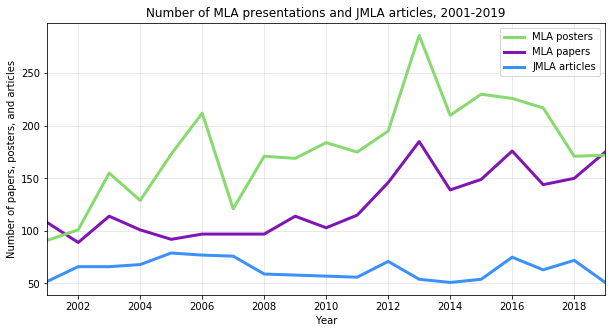

In [152]:
#group the sessions by type and year
number_papers_year = mla.groupby(['Year','Type'])["Title"].count()
#pivot
number_papers_year = number_papers_year.unstack(level=-1)
#change index of jmla to be the year so it matches the number_papers_year format
#jmla = jmla.set_index("Year") #need to uncomment this on first run-through
#concatenate jmla and mla
number_all_year = pd.concat([number_papers_year, jmla], axis=1)
number_all_year = number_all_year.rename({"Number": "JMLA articles", "paper":"MLA papers", "poster":"MLA posters"}, axis=1)

print(number_all_year)
### plot basic information
styles=["#8115b4","#88da6f","#3a91fb"]
lines = number_all_year.plot.line(figsize=(10,5), style=styles, grid="on",
                                  title="Number of MLA presentations and JMLA articles, 2001-2019", linewidth=3)

handles, labels = lines.get_legend_handles_labels()

# change the order the labels display
handles = [handles[1], handles[0], handles[2]]
labels = [labels[1], labels[0], labels[2]]

lines.legend(handles,labels)

lines.grid(alpha=.35)
lines.set(ylabel="Number of papers, posters, and articles")


fig = lines.get_figure()
fig.savefig("number of mla presentations and jmla articles.png", dpi =1000)

# Authors

## Process author data

In [28]:
# make a series with just author column
authors = mla["Authors"].astype('str') 
# get rid of word that precedes some author names
authors = authors.str.replace('and', '')
# use regex, str extract one condition at a time (the first author is the 
# characters before the first comma, additional authors come between semicolons
# and commas, semicolons, or end of lines), then concatenate those two extracted groups
first_authors = authors.str.extractall('^(.+?),')
other_authors = authors.str.extractall('(?<=\;)(.*?)(?=\,|;|$)')
all_authors = pd.concat([first_authors[0], other_authors[0]])
## convert to lowercase and remove whitespace and punctuation
all_authors = all_authors.astype('str')
all_authors = all_authors.str.strip()
all_authors = all_authors.str.lower()
all_authors = all_authors.str.replace('[^\w\s\-]','')

### Remove job/institution words

In [29]:
remove = ["library", "university", "libraries", "center", "health", \
                "director", "department", "librarian", "professor", "college",\
                "centre", "centers", "school", "hospital", "informatics", 
                "division", "services", "program", "system", "information", \
                "support", "collaboration", "coalition", "consortium", 
                "institute", "foundation", "medical", "group", "medicine"]

all_authors = all_authors[~all_authors.str.contains('|'.join(remove), na=False)]

### Pre-de-duplication count

In [30]:
### count authors - some are the same person, trying to disambiguate below
total_authors = all_authors.unique() ## 6732 authors (one is blank/no value), but some are the same person
print("There are "+str(len(total_authors))+" authors before deduplication")

There are 6733 authors before deduplication


### Normalize author names to see how many are truly unique

Change this block to Code type to run. It takes a long time to run.

In [31]:
### use this when above section is commented out or is non-running
### change this path if necessary
all_authors_normalized = pd.read_csv("normalized author list.csv", header=None)   

## Authors with the most presentations

Note: Many of these top-presenting authors present with each other, so these numbers are not mutually exclusive.

In [32]:
most_prolific = all_authors_normalized[2].value_counts()
print(most_prolific)
onepercentslice = sum(most_prolific[0:56])
onepercent = onepercentslice/len(mla)*100
twentypercentslice = sum(most_prolific[0:1135])
print(twentypercentslice)
twentypercent = twentypercentslice/len(mla)*100
more_than_19 = most_prolific[most_prolific > 18].count()
print(more_than_19)
print("The top 1% (57 out of 5681) of authors' names appeared "+str(onepercentslice)+" times")
print("The top 20% (1136 out of 5681) of authors' names appeared "+str(twentypercentslice)+" times")
print(str(more_than_19)+" authors had more than 19 presentations (an average of more than 1 per year)")

('jean p shipman', 100)           41
('patricia l thibodeau', 100)     36
('hannah f norton', 100)          36
('megan von isenburg', 100)       33
('patricia f anderson', 100)      32
('carrie l iwema', 100)           30
('michele r tennant', 100)        30
('bart ragon', 100)               29
('rick l wallace', 95)            28
('lin wu', 100)                   28
('melissa l rethlefsen', 100)     28
('kristi l holmes', 100)          27
('alisa surkis', 100)             27
('shannon d jones', 100)          26
('merle rosenzweig', 100)         25
('marie t ascher', 100)           25
('richard a peterson', 100)       24
('james shedlock', 100)           23
('jodi l philbrick', 100)         23
('beverly a murphy', 95)          21
('nancy t lombardo', 100)         21
('alexa a mayo', 95)              21
('jennifer ann lyon', 94)         20
('marisa l conte', 100)           20
('linda c odwyer', 95)            20
('tzu- heng chiu', 96)            20
('joanne rich', 100)              19
(

## Number of authors per presentation

In [33]:
### find every semicolon unless it is immediately followed by one of these stop words (to prevent
### patterns that look like: Librarian name and title; librarian name and title; university of X)
semicolons = mla.Authors.str.findall("(\;\s)(?!library|university|libraries|center|health|director|\
                                     department|librarian|professor|college|centre|centers|school|\
                                     hospital|informatics|division|services|program|system|\
                                     information|support|collaboration|coalition|consortium|\
                                     institute|foundation|medical|group|medicine|vivo\
                                     )",flags=re.IGNORECASE).str.len()
### add 1 because first/solo authors are not preceded by a semicolon
semicolons = semicolons + 1
semicolons = semicolons.fillna(0).astype(int)
mla["Number of Authors"] = semicolons
print(mla["Number of Authors"].value_counts(ascending = False))

1     2193
3     1011
2      882
4      736
5      399
6      235
7      138
8       73
9       52
10      24
11      12
12      10
0        4
15       3
14       3
13       2
17       1
18       1
26       1
23       1
Name: Number of Authors, dtype: int64


## Average number of authors over time

     Number of Authors       
Type             paper poster
Year                         
2001              2.07   2.77
2002              1.62   2.51
2003              2.37   2.61
2004              2.17   2.55
2005              1.93   2.71
2006              1.61   2.37
2007              2.52   3.17
2008              2.53   3.09
2009              2.45   3.50
2010              2.80   3.38
2011              2.88   3.45
2012              2.62   3.14
2013              2.97   3.19
2014              2.35   3.04
2015              2.44   2.87
2016              2.90   2.70
2017              2.84   2.78
2018              2.86   2.94
2019              3.19   2.66


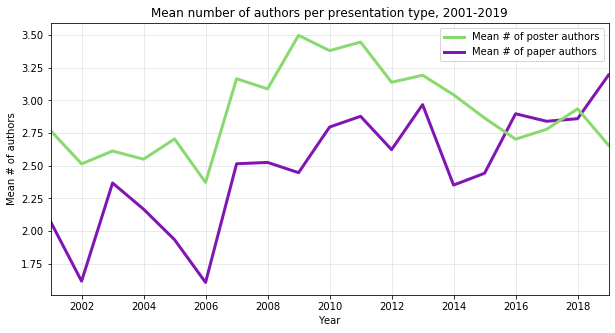

In [151]:
avg_authors_year = mla[["Year","Number of Authors","Type"]].copy()
avg_authors_year = avg_authors_year.groupby(["Year", "Type"], as_index=False).mean()
avg_authors_year = avg_authors_year.pivot(index="Year", columns="Type")
avg_authors_year_rounded = round(avg_authors_year, 2)
print(avg_authors_year_rounded)

### plot
ax2 = avg_authors_year.plot.line(figsize=(10,5), style=["#8115b4","#88da6f"], grid="on",
                                 title="Mean number of authors per presentation type, 2001-2019", linewidth=3)

handles, labels = ax2.get_legend_handles_labels()

# change the order the labels display
handles = [handles[1], handles[0]]
labels = [labels[1], labels[0]]

ax2.legend(handles,["Mean # of poster authors", "Mean # of paper authors"])


ax2.set(ylabel="Mean # of authors")
ax2.grid(alpha=.35)
fig2 = ax2.get_figure()
fig2.savefig("mean number of authors per presentation type.png", dpi =1000)

## USA authors

In [14]:
### number of records by state affiliation
state_counts = []
state_list = [
r"(\bAlabama\b|\bAL\b)",
r"(\bAlaska\b|\bAK\b)",
r"(\bArizona\b|\bAZ\b)",
r"(\bArkansas\b|\bAR\b)",
r"(\bCalifornia\b|\bCA\b)",
r"(\bColorado\b|\bCO\b)",
r"(\bConnecticut\b|\bCT\b)",
r"(\bDelaware\b|\bDE\b)",
r"(\bFlorida\b|\bFL\b)",
r"(\bGeorgia\b|\bGA\b)",
r"(\bHawaii\b|\bHI\b)",
r"(\bIdaho\b|\bID\b)",
r"(\bIllinois\b|\bIL\b)",
r"(\bIndiana\b|\bIN\b)",
r"(\bIowa\b|\bIA\b)",
r"(\bKansas\b|\bKS\b)",
r"(\bKentucky\b|\bKY\b)",
r"(\bLouisiana\b|\bLA\b)",
r"(\bMaine\b|\bME\b)",
r"(\bMaryland\b|\bMD\b)",
r"(\bMassachusetts\b|\bMA\b)",
r"(\bMichigan\b|\bMI\b)",
r"(\bMinnesota\b|\bMN\b)",
r"(\bMississippi\b|\bMS\b)",
r"(\bMissouri\b|\bMO\b)",
r"(\bMontana\b|\bMT\b)",
r"(\bNebraska\b|\bNE\b)",
r"(\bNevada\b|\bNV\b)",
r"(\bNew Hampshire\b|\bNH\b)",
r"(\bNew Jersey\b|\bNJ\b)",
r"(\bNew Mexico\b|\bNM\b)",
r"(\bNew York\b|\bNY\b)",
r"(\bNorth Carolina\b|\bNC\b)",
r"(\bNorth Dakota\b|\bND\b)",
r"(\bOhio\b|\bOH\b)",
r"(\bOklahoma\b|\bOK\b)",
r"(\bOregon\b|\bOR\b)",
r"(\bPennsylvania\b|\bPA\b)",
r"(\bRhode Island\b|\bRI\b)",
r"(\bSouth Carolina\b|\bSC\b)",
r"(\bSouth Dakota\b|\bSD\b)",
r"(\bTennessee\b|\bTN\b)",
r"(\bTexas\b|\bTX\b)",
r"(\bUtah\b|\bUT\b)",
r"(\bVermont\b|\bVT\b)",
r"(\bVirginia\b|\bVA\b)",
r"(\bWashington\b|\bWA\b)",
r"(\bWest Virginia\b|\bWV\b)",
r"(\bWisconsin\b|\bWI\b)",
r"(\bWyoming\b|\bWY\b)",
r"(\bDistrict of Columbia\b|\bDC\b)",
r"(\bPuerto Rico\b|\bPR\b)",
r"(\bGuam\b)",
r"(\bAmerican Samoa\b)",
r"(\bU.S. Virgin Islands\b)",
r"(\bNorthern Mariana Islands\b)"
]

for state in state_list:
    occurs = mla["Authors"].str.extract(state,expand=False,flags=re.IGNORECASE).fillna(np.nan)
    occurrence = occurs.value_counts()
    total_occurrence = sum(occurrence)
    if occurrence.any():
        state_counts.append((state, total_occurrence))

state_counts.sort(key=lambda tup: tup[1], reverse=True)

### turn into dataframe so it's prettier
state_counts_df = pd.DataFrame(state_counts, columns=["State", "Count"])

### replace the regex formatting so the state name is neat
state_counts_df["State"].replace(regex=True,inplace=True,to_replace=r'\(|\)|\\b',value=r'')
state_counts_df["State"].replace(regex=True,inplace=True,to_replace=r'\|',value=r' - ')
#display(state_counts_df)

### dataframe with abbreviations removed
#state_counts_map = state_counts_df.copy()
#state_counts_map["State"].replace(regex=True,inplace=True,to_replace=r'\s\-\s(.)*',value=r'')
#display(state_counts_map)

### dataframe with only abbreviations
state_counts_map = state_counts_df.copy()
state_counts_map["State"].replace(regex=True,inplace=True,to_replace=r'(.)*\s\-\s',value=r'')

### totals
print("There were "+ str(sum(state_counts_map["Count"])) +" instances where a US state name appeared at least once in a record")

### since that number includes Guam, subtract the total for Guam

### display
display(state_counts_map)

There were 7420 instances where a US state name appeared at least once in a record


,State,Count
0,MD,501
1,CA,473
2,NY,455
3,WA,419
4,PA,358
5,VA,342
6,MI,336
7,NC,327
8,TX,308
9,IL,294


## Plotting US authorship

In [34]:
import plotly
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations = state_counts_map['State'], # Spatial coordinates
    z = state_counts_map["Count"].astype(int), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'PuBu',
    colorbar_title = "# of times<br>each state appears<br>at least once<br>in the Author field<br>",
))

fig.update_layout(
    title_text = 'US-affiliated authors, 2001-2019',
    geo_scope='usa', # limit map scope to USA
)

fig.show()
### saving doesn't work, windows blocks it
plotly.io.write_image(fig, "C:/Users/bmyers/mla jupyter/usamap.png", width=1000)

### screenshot
import plotly.offline as offline
offline.plot(fig,
#             auto_open=False, image = 'png', image_filename='authors_by_state',
#             output_type='file', image_width=800, image_height=600, 
             filename='authors_by_state.html', validate=False)

'authors_by_state.html'

## International authors

In [16]:
### this loops through the list and extracts once per country, so it shows how many
### times each country appears at least once in the records
country_counts = []
country_list = ["Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua", 
                "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", 
                "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", 
                "Bhutan", "Bolivia", "Bosnia Herzegovina", "Botswana", "Brazil", "Brunei", 
                "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", 
                "Central African", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", 
                "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", 
                "Dominica", "Dominican Republic", "East Timor", "Ecuador", "Egypt", "El Salvador", 
                "Equatorial Guinea", "Eritrea", "Estonia", "Ethiopia", "Fiji", "Finland", "France", 
                "Gabon", "Gambia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea",
                "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", 
                "Indonesia", "Iran", "Iraq", "Ireland", "Israel", "Italy", "Ivory Coast", "Japan", 
                "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", 
                "Latvia", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", 
                "Macedonia", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", 
                "Marshall Islands", "Mauritania", "Mauritius", r"(?<!New\s)Mexico", "Micronesia", 
                "Moldova", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar", "Burma", 
                "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", 
                "Nigeria", "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", 
                "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", 
                "Russian Federation", "Russia", "Rwanda", r"(?:St\.?|Saint\s)Kitts", 
                r"(?:St\.?|Saint\s)Lucia", r"(?:St\.?|Saint\s)Vincent", "Samoa", "San Marino", 
                "Sao Tome", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", 
                "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", 
                "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Swaziland", "Sweden", 
                "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Togo", 
                "Tonga", "Trinidad", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", 
                "Ukraine", "United Arab Emirates", "UAE", "United Kingdom",  "UK", "Uruguay", 
                "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"]
for country in country_list:
    country_regex = r"(\b"+country+r"\b)"
    occurs = mla["Authors"].str.extract(country_regex,expand=False,flags=re.IGNORECASE).fillna(np.nan)
    occurrence = occurs.value_counts()
    if occurrence.any():
        country_counts.append((country,occurrence.item()))
country_counts.sort(key=lambda tup: tup[1], reverse=True)

### turn into dataframe so it's prettier
country_counts_df = pd.DataFrame(country_counts, columns=["Country", "Count"])
### replace the regex that was needed for Mexico so the name is neat
country_counts_df["Country"].loc[country_counts_df["Country"] == "(?<!New\s)Mexico"] = "Mexico"
display(country_counts_df)

C:\Users\bmyers\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Country,Count
0,Canada,193
1,United Kingdom,81
2,Taiwan,38
3,China,22
4,Japan,22
5,Australia,19
6,Nigeria,11
7,Netherlands,10
8,India,9
9,Israel,8


# Hospital vs. academic library affiliations

In [142]:
### keywords to look for
hospital_type_keywords = r"(\bhospital\b|\bhealth center\b|\bhealth system\b|\bmedical center\b|\bclinic\b)"
academic_type_keywords = r"(\buniversity\b|\bcollege\b|\bschool\b|\bdepartment\b)"
hospital_academic_type_keywords = r"(\bhospital\b|\bhealth center\b|\bhealth system\b|\bmedical center\b|\bclinic\b|\buniversity\b|\bcollege\b|\bschool\b|\bdepartment\b)"

def find_regex(regex_keywords): ### function to find keywords
    results = mla["Authors"].str.extract(regex_keywords,expand=False,flags=re.IGNORECASE).fillna(np.nan)
    return results

hospital = find_regex(hospital_type_keywords)
print(hospital.value_counts())
print("There are "+str(hospital.loc[hospital != False].count())+" records where the Author field includes a hospital-related keyword")

academic = find_regex(academic_type_keywords)
print(academic.value_counts())
print("There are "+str(academic.loc[academic != False].count())+" records where the Author field includes an academic-related keyword")

### number of records that do & do not include either an academic or a hospital keyword
both = mla["Authors"].str.extract(hospital_academic_type_keywords,expand=False,flags=re.IGNORECASE)
both = both.dropna()

neither = mla[~mla.index.isin(both.index)]

neither = neither.drop(['Title', "Abstract","Type","URL","Number of Authors","Year"], 1)

print("There are "+str(both.loc[both != False].count())+" records that contain either a hospital-related keyword or an academic-related keyword")
print("There are "+str(len(neither))+" records that do not contain either a hospital-related keyword or an academic-related keyword")

Medical Center    584
Hospital          309
Health System      97
Clinic             82
Health Center      19
medical center      1
hospital            1
Name: Authors, dtype: int64
There are 1093 records where the Author field includes a hospital-related keyword
University    3374
School         485
College        354
Department     268
university      24
department       9
school           2
UNIVERSITY       1
Name: Authors, dtype: int64
There are 4517 records where the Author field includes an academic-related keyword
There are 4893 records that contain either a hospital-related keyword or an academic-related keyword
There are 888 records that do not contain either a hospital-related keyword or an academic-related keyword


## Plot hospital, academic

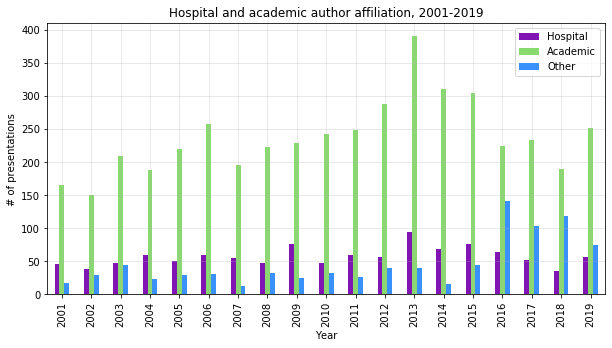

In [150]:
author_inst_type = pd.concat([mla["Year"], hospital, academic, neither], axis=1)

colnames = ["Year", "Hospital", "Academic", "Other"]
author_inst_type.columns = colnames

author_inst_type_by_year = author_inst_type.groupby("Year")[["Hospital", "Academic", "Other"]]
author_inst_type_by_year = author_inst_type_by_year.count()

ax3 = author_inst_type_by_year.plot.bar(figsize=(10,5), color=["#8115b4","#88da6f","#3a91fb"], grid="on",
                                        title="Hospital and academic author affiliation, 2001-2019")

ax3.set(ylabel="# of presentations")
ax3.grid(alpha=.35)
fig3 = ax3.get_figure()
ax3.legend(["Hospital", "Academic","Other"])
fig3.savefig("hospital academic authors.png", dpi =1000)